# 使用 qwen1.5-14b-chat-gptq-int4 + vllm部署 + openai 调用  

- https://docs.vllm.ai/en/stable/serving/openai_compatible_server.html

参数说明： 
- https://www.cnblogs.com/ghj1976/p/openaicompletioncreate-jie-kou-can-shu-shuo-ming.html  

模型显存占用 9.2905 GB 

## 注意 : 

- 运行代码前，先手动使用这个命令进行 vllm （0.4.2）的模型部署 qwen1.5-14b-chat-gptq-int4 
- 运行代码为：

```shell 
CUDA_VISIBLE_DEVICES=0 python -m vllm.entrypoints.openai.api_server --host 0.0.0.0 --port 5000 --served-model-name Qwen1.5-14B-Chat-GPTQ-Int4 --model /mntdata/wangql43/A000Files/A003Model/qwen/Qwen1.5-14B-Chat-GPTQ-Int4/ --quantization gptq --max-model-len 8192 --gpu-memory-utilization 0.8

```


- 部署成功后的截图：
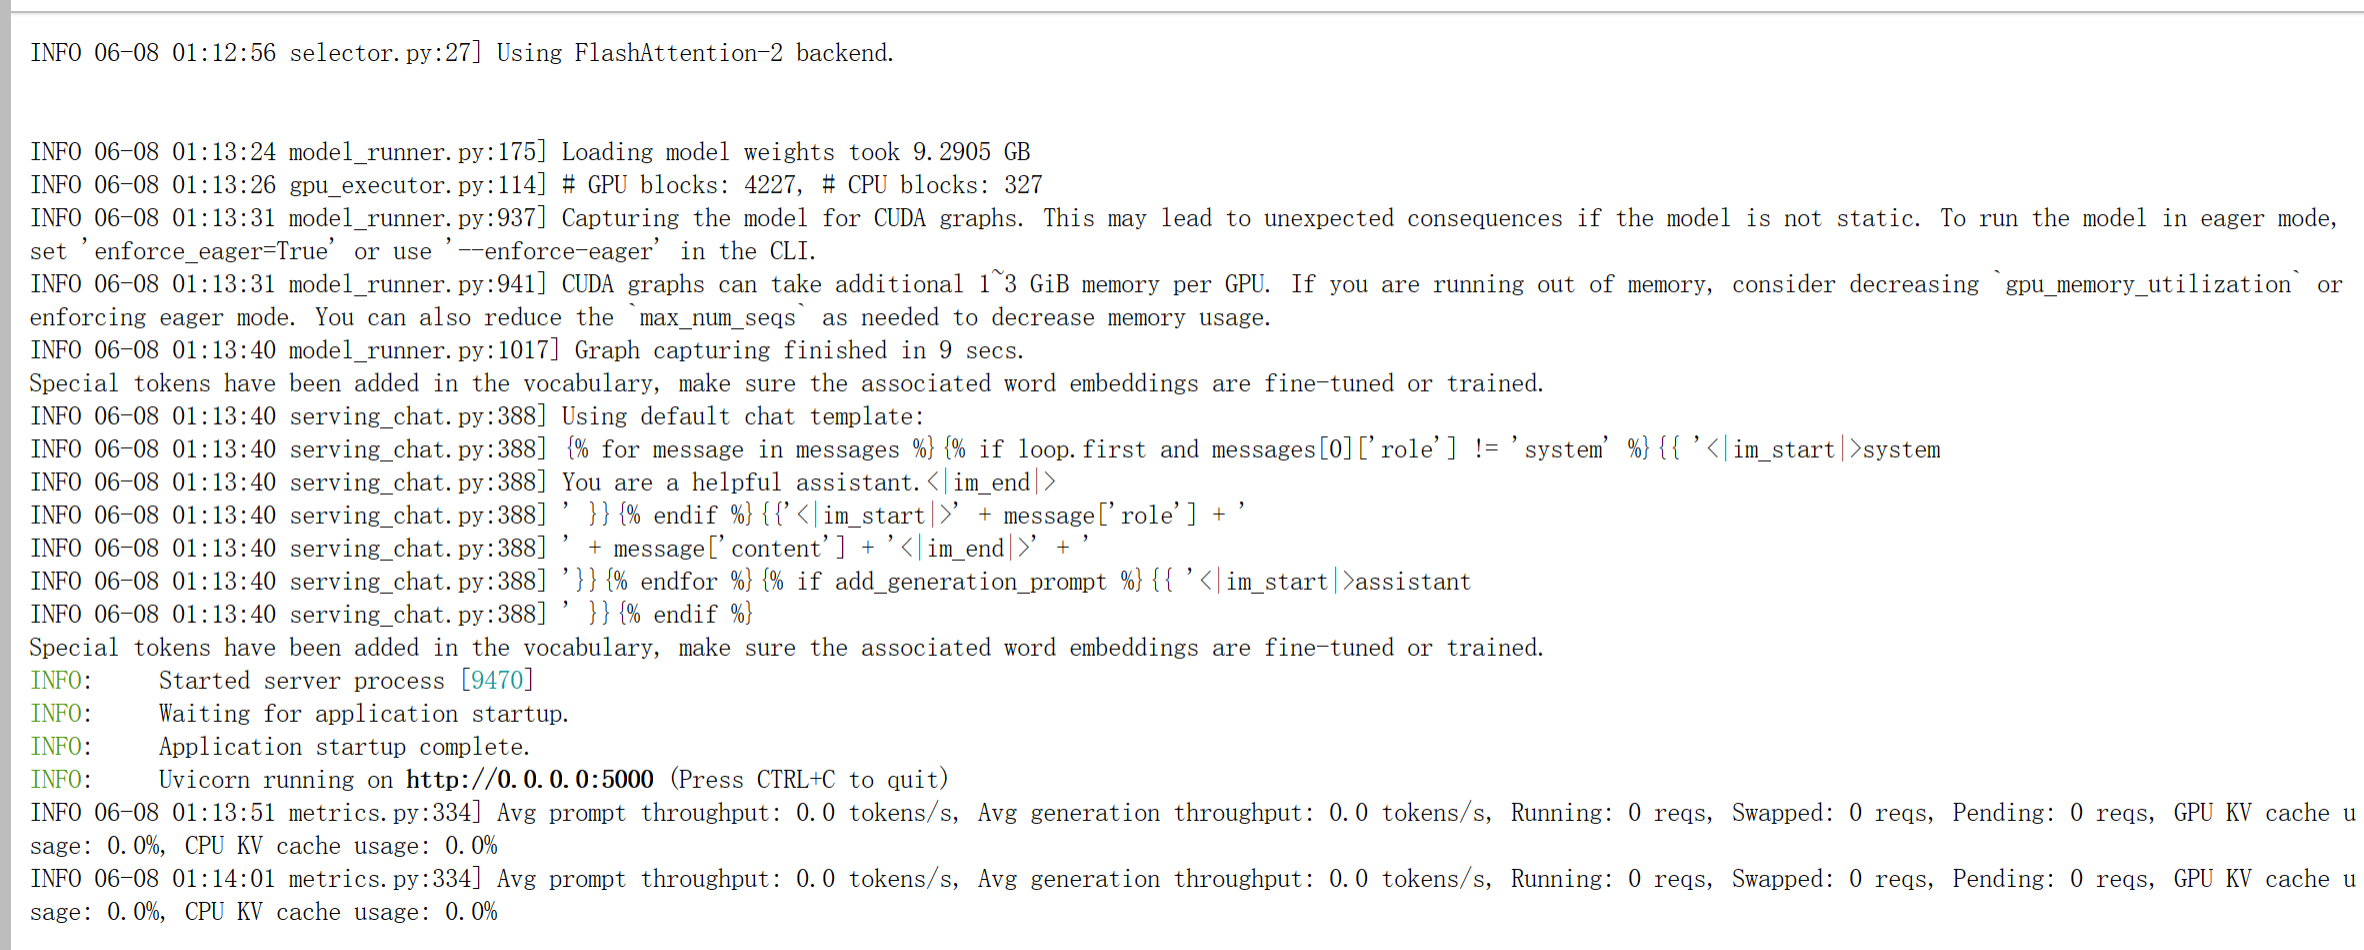



- 启动之后，使用 openai 的调用方式，简单调用接口测试！！
- 执行下面的 openai 调用的 python 代码
- 如果有输出，则说明部署正确。

In [2]:
## openai 调用已经部署的模型 
from openai import OpenAI
client = OpenAI(base_url="http://0.0.0.0:5000/v1", api_key="EMPTY")

completion = client.chat.completions.create(
    model="Qwen1.5-14B-Chat-GPTQ-Int4",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "hi, how are you"},
    ], 
    temperature=0.45,
    max_tokens=2048,
    top_p=0.7,
    n=1,
    frequency_penalty=0.5,
    presence_penalty=0.6,
    stop=None
)
response = completion.choices[0].message.content
response 

"Hello! As an AI, I don't have feelings, but I'm here to help you with any questions or tasks you have. How can I assist you today?"

# Lib

In [3]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'

import glob
import pandas as pd
import json
import re 

import random 
random.seed(0)

# 读取数据

In [4]:
## 读取数据的内容 
def read_train_valid_test(path): 
    data = []
    
    assert path.endswith('.txt')
    # 打开并逐行读取txt文件
    with open(path, 'r') as f:
        for line in f:
            # 使用json.loads将每一行转换为字典
            data.append(json.loads(line))
            
    ## 转换成 df 格式 
    data = pd.DataFrame(data)
    return data 

def read_json_to_df(json_path): 
    # 打开json文件
    with open(json_path, 'r') as file:
        # 解析json文件
        data = json.load(file)
    ## json --> df 
    data = pd.DataFrame(data).T.reset_index(names=['pids'])
    return data

## 清洗数据 
def clean_body_remove_symbol(text): 
    ## clean_body_remove_symbol(text) 
    text = re.sub('<[^<]+?>', ' ', text).replace('\n', '').strip()
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('http://', '').replace('https://', '').replace('.com', '').replace('.cn', '')
    return text 

## data
trpath = 'data/AQA/qa_train.txt'
train = read_train_valid_test(trpath)

valpath = 'data/AQA/qa_valid_wo_ans.txt'
valid = read_train_valid_test(valpath)

testpath = 'data/AQA-test-public/qa_test_wo_ans_new.txt'
test = read_train_valid_test(testpath)

## json  
json_path = 'data/AQA/pid_to_title_abs_new.json'
df_json_old = read_json_to_df(json_path) 

json_path = 'data/AQA-test-public/pid_to_title_abs_update_filter.json'
df_json_new = read_json_to_df(json_path) 

len(set(df_json_new['pids']).difference(set(df_json_old['pids'])))
df_json = pd.merge(df_json_new, df_json_old, how='outer', on=['pids', 'title', 'abstract'])

del df_json_new, df_json_old

##
train.isnull().sum()
valid.isnull().sum()
df_json.isnull().sum()

## train 中的 body 内容给定 
train['body'] = train['body'].apply(clean_body_remove_symbol)
valid['body'] = valid['body'].apply(clean_body_remove_symbol)
test['body'] = test['body'].apply(clean_body_remove_symbol)

## passage 文章清洗 
df_json['title'] = df_json['title'].fillna('None').apply(clean_body_remove_symbol) 
df_json['abstract'] = df_json['abstract'].apply(clean_body_remove_symbol) 

df_json = df_json.reset_index()
df_json = df_json.rename(columns={'index':'id'}) 

70575

question    0
body        0
pids        0
dtype: int64

question    0
body        0
dtype: int64

pids        0
title       3
abstract    0
dtype: int64

# 调用本地 api 生成 answer 

In [5]:
from tqdm import tqdm
from langchain.prompts import PromptTemplate

In [6]:
qa_template = '''# CONTEXT #
context information: {body}

#############

# OBJECTIVE #
You are an outstanding technical expert in the field of research paper/document Q&A, with particular expertise in SCI (Science Citation Index), EI (The Engineering Index), IEEE (The Institute of Electrical and Electronics Engineers), Science and etc.
Please provide a professional response to the user's question, taking into full account the context information.
user's question：{question}
Attention: Only output the answer about this question

#############

# STYLE #
Science, Technology, Engineering, Mathematics, 
physics, chemistry, atmospheric science, biology
Natural Language Processing, Machine Learning, Deep Learning
Computer Science, Materials, mechanical engineering, electrical and electronic engineering, telecommunications, instrumentation, systems engineering

#############

# TONE #
Professional, Serious, Responsible, Accurate, and Precise.

#############'''

In [7]:
row = test.loc[0]
qa_prompt_template = PromptTemplate(input_variables=["question", 'body'], template=qa_template) 
qa_formatted_prompt = qa_prompt_template.format(question=row.question, body=row.body)

In [30]:
from openai import OpenAI
client = OpenAI(base_url="http://0.0.0.0:5000/v1", api_key="EMPTY")

In [9]:
for idx, row in tqdm(test.iterrows(), total=len(test)): 
    ## model_input 
    model_input = qa_prompt_template.format(question=row.question, body=row.body)
    
    ## ai-response
    completion = client.chat.completions.create(
        model="Qwen1.5-14B-Chat-GPTQ-Int4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": model_input},
        ], 
        temperature=0.45,
        max_tokens=2048,
        top_p=0.7,
        n=1,
        frequency_penalty=0.5,
        presence_penalty=0.6,
        stop=None
    )
    response = completion.choices[0].message.content
    test.loc[idx, 'ai_response'] = response

100%|██████████| 3000/3000 [3:05:22<00:00,  3.71s/it]  


In [26]:
test.to_parquet('outslgb/test_with_aiResponse_by_qwen14bgptqVllmPost.parquet', index=False) 

# 调用本地 api 生成 keywords 

In [31]:
from tqdm import tqdm
from langchain.prompts import PromptTemplate

In [32]:
keywords_template = '''# CONTEXT #
user's question: {question}
context information: {body}

#############

# OBJECTIVE #
You are an outstanding technical expert in the field of research paper/document Q&A, with particular expertise in SCI (Science Citation Index), EI (The Engineering Index), IEEE (The Institute of Electrical and Electronics Engineers), Science and etc.

Extract keywords from the user's question and context information.

Attention: The requirement is to output the keywords only !!!

#############

# STYLE #
Science, Technology, Engineering, Mathematics, 
physics, chemistry, atmospheric science, biology
Natural Language Processing, Machine Learning, Deep Learning
Computer Science, Materials, mechanical engineering, electrical and electronic engineering, telecommunications, instrumentation, systems engineering

#############

# TONE #
Keywords, Professional, Serious, Responsible, Accurate, and Precise.

#############'''

In [36]:
row = test.loc[0] 
keywords_prompt_template = PromptTemplate(input_variables=["question", 'body'], template=keywords_template)  
keywords_formatted_prompt = keywords_prompt_template.format(question=row.question, body=row.body) 

In [37]:
for idx, row in tqdm(test.iterrows(), total=len(test)): 
    ## 没有映射走模型  
    keywords_formatted_prompt = keywords_prompt_template.format(question=row.question, body=row.body) 
    completion = client.chat.completions.create(
        model="Qwen1.5-14B-Chat-GPTQ-Int4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": keywords_formatted_prompt},
        ], 
        temperature=0.45,
        max_tokens=512,
        top_p=0.7,
        n=1,
        frequency_penalty=0.5,
        presence_penalty=0.6,
        stop=None
    )
    response = completion.choices[0].message.content
    test.loc[idx, 'keywords'] = response.replace('Keywords', '').replace('keywords', '').replace(':', '') 

2024-06-04 10:49:29,867 HTTP Request: POST http://0.0.0.0:5000/v1/chat/completions "HTTP/1.1 200 OK"
100%|██████████| 3000/3000 [35:30<00:00,  1.41it/s]


In [40]:
test.to_parquet('outslgb/test_with_aiResponse_withKeywords_by_qwen14bgptqVllmPost.parquet', index=False) 

# 完成之后释放掉 vllm 部署的模型

具体操作：在命令终端，输入 ctrl + C 完成服务中断 